# Security & Artificial Intelligence Project

## Project objectives

The goal of the project is to design, deploy and evaluate a data chain for the analysis of
cybersecurity data. The data treatment will be performed as batch.

We chose Objective 1 :
   - Anomaly detection for tracking attacks
   
Our dataset :
   - The UGR’16 Dataset
   

Data date :
   - June - Week 1, Date range: 01/06/2016 - 05/06/2016

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import seaborn as sb
import numpy as np
import matplotlib.lines as mlines
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

Here we import our train dataset from the first week of June.

In [2]:
col_names = ["Date of the end", "Duration", "Source IP", "Destination IP", "Source Port", "Destination Port", "Protocol", "Flag", "Forwarding Status", "Type of Service", "Packets exchanged", "Bytes exchanged", "Label"]

train_df = pd.read_csv('data/train/june.week1.csv', nrows=100000, names=col_names)
train_df

,Date of the end,Duration,Source IP,Destination IP,Source Port,Destination Port,Protocol,Flag,Forwarding Status,Type of Service,Packets exchanged,Bytes exchanged,Label
0,2016-06-01 00:05:01,39.364,211.62.96.220,42.219.158.212,55107,64188,UDP,.A....,0,0,19,3958,background
1,2016-06-01 00:05:03,39.828,42.219.158.226,71.247.111.184,80,52475,TCP,.AP.S.,0,0,57,79635,background
2,2016-06-01 00:05:04,36.128,42.219.153.155,223.80.226.127,443,54691,TCP,.AP.S.,0,0,9,2791,background
3,2016-06-01 00:05:04,36.204,223.80.226.127,42.219.153.155,54691,443,TCP,.AP.S.,0,0,13,3896,background
4,2016-06-01 00:05:04,42.452,42.219.153.7,42.187.82.40,53,53,UDP,.A....,0,0,2,175,background
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2016-06-01 00:06:15,0.920,214.43.224.16,42.219.159.82,53290,21,TCP,.AP.SF,0,0,10,446,background
99996,2016-06-01 00:06:15,0.948,223.87.244.11,42.219.156.211,56056,443,TCP,.AP.SF,0,0,8,1027,background
99997,2016-06-01 00:06:15,0.952,214.43.224.16,42.219.159.82,53294,21,TCP,.AP.SF,0,0,10,446,background
99998,2016-06-01 00:06:15,0.964,211.59.135.5,42.219.159.82,41223,7070,TCP,.AP.SF,0,0,10,852,background


The test_df is for the moment the same as the train_df, need to DL it.

In [3]:
test_df = pd.read_csv('data/test/july.week5.csv', nrows=100000, names=col_names)
test_df

,Date of the end,Duration,Source IP,Destination IP,Source Port,Destination Port,Protocol,Flag,Forwarding Status,Type of Service,Packets exchanged,Bytes exchanged,Label
0,2016-07-27 13:43:21,48.380,187.96.221.207,42.219.153.7,53,53,UDP,.A....,0,0,2,209,background
1,2016-07-27 13:43:21,48.380,42.219.153.7,187.96.221.207,53,53,UDP,.A....,0,0,2,167,background
2,2016-07-27 13:43:25,50.632,42.219.153.191,62.205.150.146,80,1838,TCP,.AP...,0,0,9,2082,background
3,2016-07-27 13:43:25,51.052,62.205.150.146,42.219.153.191,1838,80,TCP,.AP...,0,0,9,7118,background
4,2016-07-27 13:43:27,46.996,92.225.28.133,42.219.155.111,443,59867,TCP,.AP...,0,0,4,674,background
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2016-07-27 13:44:44,13.216,42.219.153.89,106.150.66.78,19927,40032,UDP,.A....,0,0,2,124,background
99996,2016-07-27 13:44:44,1.324,42.219.155.28,70.134.80.110,443,53084,TCP,.APRSF,0,0,9,3292,background
99997,2016-07-27 13:44:44,132.504,42.219.147.178,78.160.191.60,11429,443,TCP,.AP.SF,0,0,114,52079,background
99998,2016-07-27 13:44:44,1.328,74.196.16.70,42.219.155.28,36032,443,TCP,.APRSF,0,0,14,2953,background


In [4]:
data = [train_df, test_df]

In [5]:
print(train_df.columns.values)

['Date of the end' 'Duration' 'Source IP' 'Destination IP' 'Source Port'
 'Destination Port' 'Protocol' 'Flag' 'Forwarding Status'
 'Type of Service' 'Packets exchanged' 'Bytes exchanged' 'Label']


**Which features are categorical?**

These values classify the samples into sets of similar samples. Within categorical features are the values nominal, ordinal, ratio, or interval based? Among other things this helps us select the appropriate plots for visualization.

- Categorical: Protocol, Label.

**Which features are numerical?**

Which features are numerical? These values change from sample to sample. Within numerical features are the values discrete, continuous, or timeseries based? Among other things this helps us select the appropriate plots for visualization.

- Continous: Date of the end, Duration, Source IP, Destination IP, Packets exchanged, Bytes exchanged. Discrete: Source Port, Destination Port, Forwarding Status, Type of Service

In [6]:
train_df.head()

,Date of the end,Duration,Source IP,Destination IP,Source Port,Destination Port,Protocol,Flag,Forwarding Status,Type of Service,Packets exchanged,Bytes exchanged,Label
0,2016-06-01 00:05:01,39.364,211.62.96.220,42.219.158.212,55107,64188,UDP,.A....,0,0,19,3958,background
1,2016-06-01 00:05:03,39.828,42.219.158.226,71.247.111.184,80,52475,TCP,.AP.S.,0,0,57,79635,background
2,2016-06-01 00:05:04,36.128,42.219.153.155,223.80.226.127,443,54691,TCP,.AP.S.,0,0,9,2791,background
3,2016-06-01 00:05:04,36.204,223.80.226.127,42.219.153.155,54691,443,TCP,.AP.S.,0,0,13,3896,background
4,2016-06-01 00:05:04,42.452,42.219.153.7,42.187.82.40,53,53,UDP,.A....,0,0,2,175,background


**Which features may contain errors or typos?**

This is harder to review for a large dataset, however reviewing a few samples from a smaller dataset may just tell us outright, which features may require correcting.

In [7]:
train_df.info()
print('_'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Date of the end    100000 non-null  object 
 1   Duration           100000 non-null  float64
 2   Source IP          100000 non-null  object 
 3   Destination IP     100000 non-null  object 
 4   Source Port        100000 non-null  int64  
 5   Destination Port   100000 non-null  int64  
 6   Protocol           100000 non-null  object 
 7   Flag               100000 non-null  object 
 8   Forwarding Status  100000 non-null  int64  
 9   Type of Service    100000 non-null  int64  
 10  Packets exchanged  100000 non-null  int64  
 11  Bytes exchanged    100000 non-null  int64  
 12  Label              100000 non-null  object 
dtypes: float64(1), int64(6), object(6)
memory usage: 9.9+ MB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10

**Which features contain blank, null or empty values?**

These will require correcting.

- None ?

In [8]:
train_df.isna().sum()

Date of the end      0
Duration             0
Source IP            0
Destination IP       0
Source Port          0
Destination Port     0
Protocol             0
Flag                 0
Forwarding Status    0
Type of Service      0
Packets exchanged    0
Bytes exchanged      0
Label                0
dtype: int64

array([[<AxesSubplot:title={'center':'Duration'}>,
        <AxesSubplot:title={'center':'Source Port'}>,
        <AxesSubplot:title={'center':'Destination Port'}>],
       [<AxesSubplot:title={'center':'Forwarding Status'}>,
        <AxesSubplot:title={'center':'Type of Service'}>,
        <AxesSubplot:title={'center':'Packets exchanged'}>],
       [<AxesSubplot:title={'center':'Bytes exchanged'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

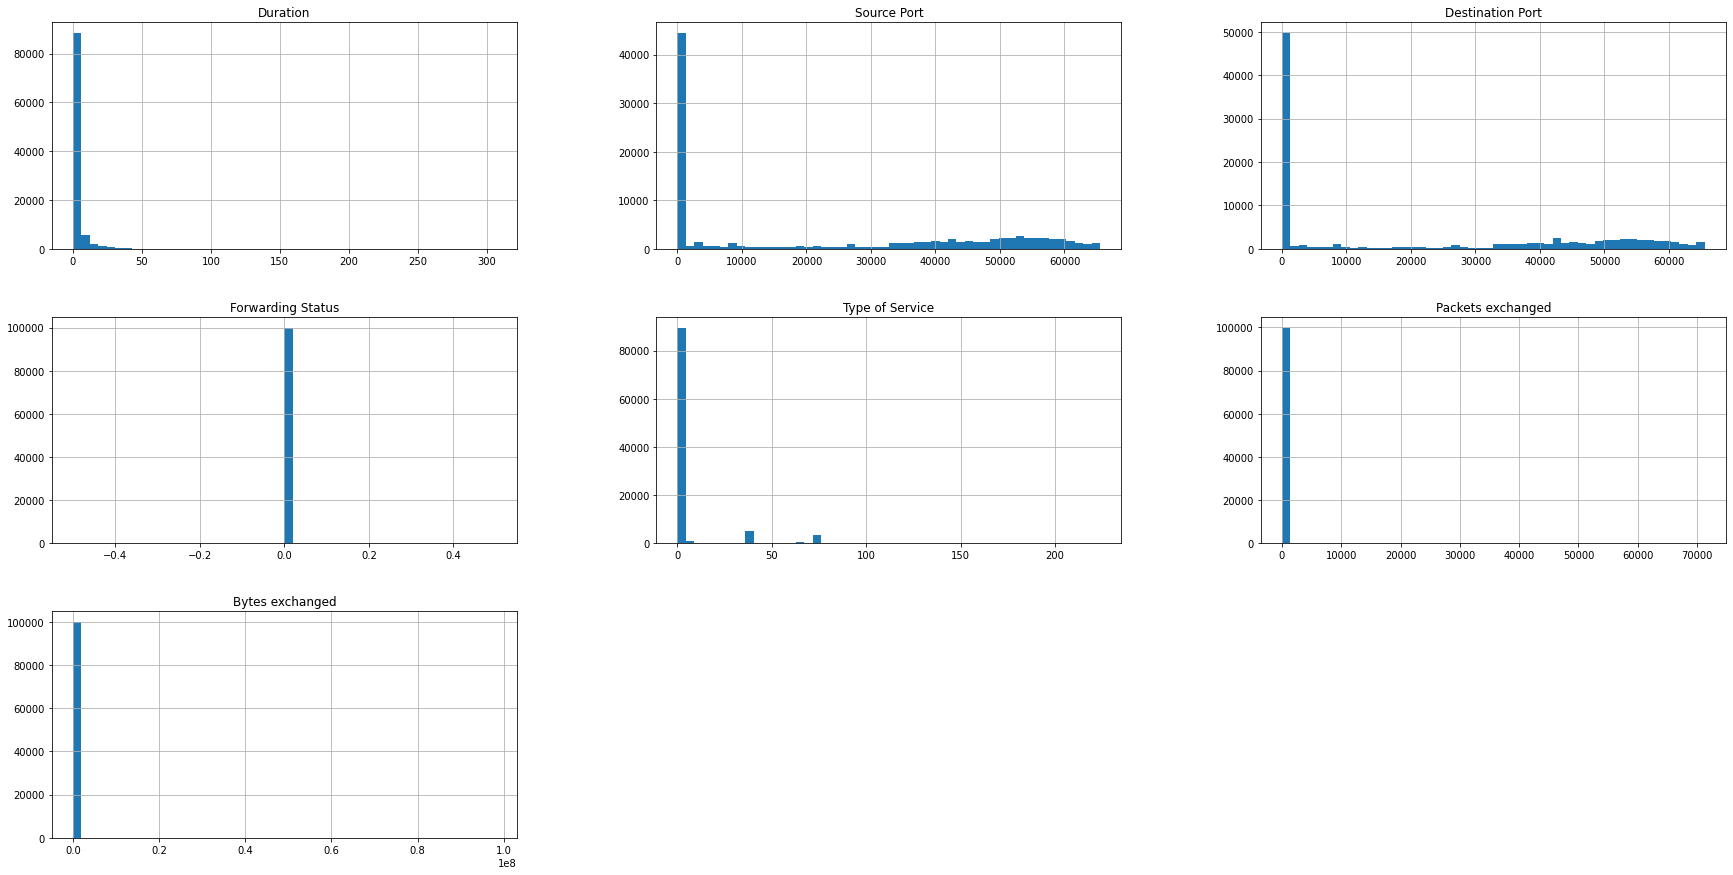

In [9]:
train_df.hist(bins=50, figsize=(30,15))

Let's get statistics about the numerical data:

In [10]:
train_df.describe()

,Duration,Source Port,Destination Port,Forwarding Status,Type of Service,Packets exchanged,Bytes exchanged
count,100000.000000,100000.000000,100000.000000,100000.0,100000.00000,100000.00000,1.000000e+05
mean,3.874456,23211.640690,21585.933740,0.0,5.48096,15.53606,9.666999e+03
std,17.367555,24256.333137,24356.418599,0.0,18.20760,412.64439,4.923387e+05
min,0.000000,0.000000,0.000000,0.0,0.00000,1.00000,2.800000e+01
25%,0.000000,80.000000,80.000000,0.0,0.00000,1.00000,9.600000e+01
50%,0.368000,11263.000000,2048.000000,0.0,0.00000,4.00000,3.550000e+02
75%,2.920000,48436.000000,46944.250000,0.0,0.00000,8.00000,1.062000e+03
max,306.560000,65535.000000,65535.000000,0.0,224.00000,71297.00000,9.814513e+07


We can see that `Source Port` and `Destination Port` are considered as numerical data, we will modify this point later by categorizing them. 

We observe that `Forwarding Status` column is full of zeroes. We decide to drop it.

In [11]:
for df in data:
    df.drop(columns='Forwarding Status', inplace=True)
train_df.head()

,Date of the end,Duration,Source IP,Destination IP,Source Port,Destination Port,Protocol,Flag,Type of Service,Packets exchanged,Bytes exchanged,Label
0,2016-06-01 00:05:01,39.364,211.62.96.220,42.219.158.212,55107,64188,UDP,.A....,0,19,3958,background
1,2016-06-01 00:05:03,39.828,42.219.158.226,71.247.111.184,80,52475,TCP,.AP.S.,0,57,79635,background
2,2016-06-01 00:05:04,36.128,42.219.153.155,223.80.226.127,443,54691,TCP,.AP.S.,0,9,2791,background
3,2016-06-01 00:05:04,36.204,223.80.226.127,42.219.153.155,54691,443,TCP,.AP.S.,0,13,3896,background
4,2016-06-01 00:05:04,42.452,42.219.153.7,42.187.82.40,53,53,UDP,.A....,0,2,175,background


Let's get statistics about the categorical data:

In [12]:
train_df.describe(include=['O'])

,Date of the end,Source IP,Destination IP,Protocol,Flag,Label
count,100000,100000,100000,100000,100000,100000
unique,73,11256,19037,7,20,2
top,2016-06-01 00:05:48,42.219.156.211,42.219.156.211,TCP,.A....,background
freq,2460,8238,7661,68269,33898,99796


In [13]:
for df in data:
    df['Date of the end'] = pd.to_datetime(df['Date of the end'])
    df['year'] = df['Date of the end'].dt.year
    df['month'] = df['Date of the end'].dt.month
    df['day'] = df['Date of the end'].dt.day
    df['week'] = df['Date of the end'].dt.isocalendar().week
    df['hour'] = df['Date of the end'].dt.hour
    df['minute'] = df['Date of the end'].dt.minute
    df['second'] = df['Date of the end'].dt.second
    df['dayOfWeek'] = df['Date of the end'].dt.dayofweek
    df.drop(columns='Date of the end', inplace=True)

We encode categorical data with an Ordinal Encoder

In [42]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

In [17]:
for df in data:
    df['Source Port'] = df['Source Port'].astype(object)
    df['Destination Port'] = df['Destination Port'].astype(object)

In [18]:
train_df.describe(include=['O'])

,Source IP,Destination IP,Source Port,Destination Port,Protocol,Flag,Label
count,100000,100000,100000,100000,100000,100000,100000
unique,11256,19037,31605,28584,7,20,2
top,42.219.156.211,42.219.156.211,53,53,TCP,.A....,background
freq,8238,7661,14995,13460,68269,33898,99796


In [19]:
num_col = list(train_df._get_numeric_data().columns.values)
num_col

['Duration',
 'Type of Service',
 'Packets exchanged',
 'Bytes exchanged',
 'year',
 'month',
 'day',
 'week',
 'hour',
 'minute',
 'second',
 'dayOfWeek']

In [20]:
cat_col = list(train_df.select_dtypes(include=object).columns.values)
cat_col.remove('Label')
cat_col

['Source IP',
 'Destination IP',
 'Source Port',
 'Destination Port',
 'Protocol',
 'Flag']

In [24]:
encode = OrdinalEncoder()
data[0] = data[0].assign(Label=encode.fit_transform(data[0]['Label'].values.reshape(-1,1)))
data[1] = data[1].assign(Label=encode.fit_transform(data[1]['Label'].values.reshape(-1,1)))

KeyError: 'Label'

In [25]:
transformer = make_column_transformer(
    (OneHotEncoder(handle_unknown= 'ignore'), cat_col))

In [26]:
Y_train = data[0].pop("Label")
X_train = data[0]

KeyError: 'Label'

In [30]:
Y_test = data[1].pop("Label")
X_test = data[1]

In [43]:
classifier_score = {}

In [44]:
def classifier_testing(classifier):
    print(f"Testing {classifier[0]}...")
    pipeline = Pipeline([
        ('transformer', transformer),
        ('classifier', classifier[1]),
    ])
    print("Fitting...")
    pipeline.fit(X_train, Y_train)
    print("Predicting...")
    y_pred = pipeline.predict(X_test)
    print("Scoring...")
    score = f1_score(Y_test, y_pred)
    print(f"{classifier[0]} score : {score}")
    classifier_score[classifier[0]] = score

In [50]:
classifiers = {
    "Perceptron" : Perceptron(),
    "SGD" : SGDClassifier(),
    "DecisionTree" : DecisionTreeClassifier()
}

In [51]:
for key, value in classifiers.items():
    classifier_testing((key, value))

Testing Perceptron...
Fitting...
Predicting...
Scoring...
Perceptron score : 0.880354505169867
Testing SGD...
Fitting...
Predicting...
Scoring...
SGD score : 0.8699551569506727
Testing DecisionTree...
Fitting...
Predicting...
Scoring...
DecisionTree score : 0.8748159057437408


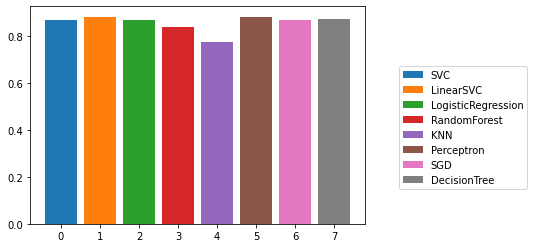

In [52]:
for i, test in enumerate(classifier_score.items()):
    plt.bar(i, test[1], label=test[0])
plt.legend(bbox_to_anchor=(1, 0.25, 0.5, 0.5))

In [81]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
import time

In [82]:
epochs = 3
batch_size = 50
sequence_length = 100

In [83]:
def generate_model():
    model = Sequential()
    
    # First LSTM layer defining the input sequence length
    model.add(LSTM(input_shape=(sequence_length-1, 1),
                   units=32,
                   return_sequence=True))

    model.add(Dropout(0.2))
    
    # Second LSTM layer with 128 units
    model.add(LSTM(units=128,
                   return_sequence=True))
    model.add(Dropout(0.2))
    
    # Third LSTM layer with 100 units
    model.add(LSTM(units=100,
                   return_sequence=True))
    model.add(Dropout(0.2))
    
    # Densely-connected output layer with the linear activation function
    model.add(Dense(units=1))
    model.add(Activation('linear'))
    
    model.compile(loss='mean_squared_error', optimizer='rmsprop')
    return model

In [84]:
def normalize(result):
    result_mean = result.mean()
    result_std = result.std()
    result -= result_mean
    result /= result_std
    return result, result_mean

In [85]:
def prepare_data(data, train_start, train_end, test_start, test_end):
    print("Length of Data", len(data))
    
    # training data
    print("Creating training data...")
    
    result = []
    for index in range(train_start, train_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)
    result, result_mean = normalize(result)
    
    print("Training data shape : ", result.shape)
    
    train = result[train_start:train_end, :]
    np.random.shuffle(train)
    X_train = train[:, :-1]
    Y_train = train[:, -1]
    
    # test data
    print("Creating test data...")
    
    result = []
    for index in range(test_start, test_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)
    result, result_mean = normalize(result)
    
    print("Test data shape : ", result.shape)
    
    X_test = result[: , :-1]
    Y_test = result[:, -1]
    
    print("Shape X_train", np.shape(X_train))
    print("Shape X_test", np.shape(X_test))
    
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    return X_train, Y_train, X_test, Y_test

In [93]:
def run(model=None, data=None):
    global_start_time = time.time()
    
    print("Loading data...")
    
    X_train, Y_train, X_test, Y_test = prepare_data(data, 0, 600, 400, 660)
    
    if model is None:
        model = generate_model()
    
    try:
        print("Training ...")
        model.fit(
            X_train, Y_train,
            batch_size=batch_size, epochs=epochs, validation_split=0.05
        )
        print("Predicting...")
        predicted = model.predict(X_test)
        print("Reshaping predicted")
        predicted = np.reshape(predicted, (predicted.size,))
    except KeyboardInterrupt:
        print('Prediction exception')
        print(f'Training duration: {time.time() - global_start_time}')
        return model, Y_test, 0
    
    try:
        plt.figure(figsize=(20,8))
        plt.plot(Y_test[:len(Y_test)], 'b', label='Observed')
        plt.plot(predicted[:len(Y_test)], 'g', label='Predicted')
        plt.plot(((Y_test - predicted) ** 2), 'r', label='Root-mean-square deviation')
        plt.legend()
        plt.show()
    except Exception as e:
        print("plotting exception")
        print(str(e))
    print(f"Training duration : {time.time() - global_start_time}")

    return model, Y_test, predicted

In [94]:
model, Y_test, predicted = run(data=train_df)

Loading data...
Length of Data 100000
Creating training data...


TypeError: can only concatenate str (not "float") to str

In [3]:
df_blacklist = data_june[data_june['Label'] == 'blacklist'].head(300)
df_blacklist

,Date of the end,Duration,Source IP,Destination IP,Source Port,Destination Port,Protocol,Flag,Forwarding Status,Type of Service,Packets exchanged,Bytes exchanged,Label
1025,2016-06-01 00:05:09,0.000,42.219.158.188,57.183.171.2,53,46937,UDP,.A....,0,0,1,82,blacklist
1026,2016-06-01 00:05:09,0.000,42.219.158.188,57.183.171.2,53,56796,UDP,.A....,0,0,1,102,blacklist
3561,2016-06-01 00:05:12,0.000,143.72.8.137,42.219.158.188,53,34566,UDP,.A....,0,0,1,324,blacklist
3595,2016-06-01 00:05:12,0.000,204.97.46.104,42.219.158.188,62676,53,UDP,.A....,0,0,1,81,blacklist
3605,2016-06-01 00:05:12,0.000,204.97.73.58,42.219.158.188,61117,53,UDP,.A....,0,0,1,81,blacklist
...,...,...,...,...,...,...,...,...,...,...,...,...,...
183602,2016-06-01 00:07:06,0.000,42.219.158.188,71.163.54.234,80,3191,TCP,.A...F,0,0,1,52,blacklist
183603,2016-06-01 00:07:06,0.000,42.219.158.188,71.163.54.234,80,8040,TCP,.A...F,0,0,1,52,blacklist
183947,2016-06-01 00:07:06,0.208,71.163.54.234,42.219.158.188,29727,80,TCP,.A...F,0,0,2,104,blacklist
183951,2016-06-01 00:07:06,0.212,71.163.54.234,42.219.158.188,8040,80,TCP,.A...F,0,0,2,104,blacklist


In [4]:
df_background = data_june[data_june['Label'] == 'background'].head(9700)
df_background

,Date of the end,Duration,Source IP,Destination IP,Source Port,Destination Port,Protocol,Flag,Forwarding Status,Type of Service,Packets exchanged,Bytes exchanged,Label
0,2016-06-01 00:05:01,39.364,211.62.96.220,42.219.158.212,55107,64188,UDP,.A....,0,0,19,3958,background
1,2016-06-01 00:05:03,39.828,42.219.158.226,71.247.111.184,80,52475,TCP,.AP.S.,0,0,57,79635,background
2,2016-06-01 00:05:04,36.128,42.219.153.155,223.80.226.127,443,54691,TCP,.AP.S.,0,0,9,2791,background
3,2016-06-01 00:05:04,36.204,223.80.226.127,42.219.153.155,54691,443,TCP,.AP.S.,0,0,13,3896,background
4,2016-06-01 00:05:04,42.452,42.219.153.7,42.187.82.40,53,53,UDP,.A....,0,0,2,175,background
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9707,2016-06-01 00:05:17,0.472,253.139.127.229,42.219.156.191,25,51494,TCP,.AP.SF,0,0,5,416,background
9708,2016-06-01 00:05:17,0.472,253.139.127.229,42.219.156.191,25,57120,TCP,.AP.SF,0,0,5,416,background
9709,2016-06-01 00:05:17,0.472,253.139.127.230,42.219.156.183,25,36719,TCP,.AP.SF,0,0,5,416,background
9710,2016-06-01 00:05:17,0.472,253.139.127.230,42.219.156.183,25,40526,TCP,.AP.SF,0,0,5,416,background


In [5]:
df_reduced = pd.concat([df_background, df_blacklist])
df_reduced

,Date of the end,Duration,Source IP,Destination IP,Source Port,Destination Port,Protocol,Flag,Forwarding Status,Type of Service,Packets exchanged,Bytes exchanged,Label
0,2016-06-01 00:05:01,39.364,211.62.96.220,42.219.158.212,55107,64188,UDP,.A....,0,0,19,3958,background
1,2016-06-01 00:05:03,39.828,42.219.158.226,71.247.111.184,80,52475,TCP,.AP.S.,0,0,57,79635,background
2,2016-06-01 00:05:04,36.128,42.219.153.155,223.80.226.127,443,54691,TCP,.AP.S.,0,0,9,2791,background
3,2016-06-01 00:05:04,36.204,223.80.226.127,42.219.153.155,54691,443,TCP,.AP.S.,0,0,13,3896,background
4,2016-06-01 00:05:04,42.452,42.219.153.7,42.187.82.40,53,53,UDP,.A....,0,0,2,175,background
...,...,...,...,...,...,...,...,...,...,...,...,...,...
183602,2016-06-01 00:07:06,0.000,42.219.158.188,71.163.54.234,80,3191,TCP,.A...F,0,0,1,52,blacklist
183603,2016-06-01 00:07:06,0.000,42.219.158.188,71.163.54.234,80,8040,TCP,.A...F,0,0,1,52,blacklist
183947,2016-06-01 00:07:06,0.208,71.163.54.234,42.219.158.188,29727,80,TCP,.A...F,0,0,2,104,blacklist
183951,2016-06-01 00:07:06,0.212,71.163.54.234,42.219.158.188,8040,80,TCP,.A...F,0,0,2,104,blacklist


In [6]:
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 183965
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date of the end    10000 non-null  object 
 1   Duration           10000 non-null  float64
 2   Source IP          10000 non-null  object 
 3   Destination IP     10000 non-null  object 
 4   Source Port        10000 non-null  int64  
 5   Destination Port   10000 non-null  int64  
 6   Protocol           10000 non-null  object 
 7   Flag               10000 non-null  object 
 8   Forwarding Status  10000 non-null  int64  
 9   Type of Service    10000 non-null  int64  
 10  Packets exchanged  10000 non-null  int64  
 11  Bytes exchanged    10000 non-null  int64  
 12  Label              10000 non-null  object 
dtypes: float64(1), int64(6), object(6)
memory usage: 1.1+ MB


In [7]:
print(f"Rate of blacklist netflow : {len(df_reduced[df_reduced['Label'] == 'blacklist']) / len(df_reduced) * 100}%")

Rate of blacklist netflow : 3.0%


In [8]:
print("Categorical Columns : ", list(df_reduced.select_dtypes(include=object)))

Categorical Columns :  ['Date of the end', 'Source IP', 'Destination IP', 'Protocol', 'Flag', 'Label']


In [9]:
print("Numerical Columns : ", list(df_reduced._get_numeric_data()))

Numerical Columns :  ['Duration', 'Source Port', 'Destination Port', 'Forwarding Status', 'Type of Service', 'Packets exchanged', 'Bytes exchanged']


In [10]:
ord_encode = OrdinalEncoder()

In [11]:
col_encoded = ord_encode.fit_transform(df_reduced['Label'].values.reshape(-1,1))
col_encoded

array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]])

In [12]:
df_encoded = df_reduced.assign(Label=col_encoded)
df_encoded

,Date of the end,Duration,Source IP,Destination IP,Source Port,Destination Port,Protocol,Flag,Forwarding Status,Type of Service,Packets exchanged,Bytes exchanged,Label
0,2016-06-01 00:05:01,39.364,211.62.96.220,42.219.158.212,55107,64188,UDP,.A....,0,0,19,3958,0.0
1,2016-06-01 00:05:03,39.828,42.219.158.226,71.247.111.184,80,52475,TCP,.AP.S.,0,0,57,79635,0.0
2,2016-06-01 00:05:04,36.128,42.219.153.155,223.80.226.127,443,54691,TCP,.AP.S.,0,0,9,2791,0.0
3,2016-06-01 00:05:04,36.204,223.80.226.127,42.219.153.155,54691,443,TCP,.AP.S.,0,0,13,3896,0.0
4,2016-06-01 00:05:04,42.452,42.219.153.7,42.187.82.40,53,53,UDP,.A....,0,0,2,175,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
183602,2016-06-01 00:07:06,0.000,42.219.158.188,71.163.54.234,80,3191,TCP,.A...F,0,0,1,52,1.0
183603,2016-06-01 00:07:06,0.000,42.219.158.188,71.163.54.234,80,8040,TCP,.A...F,0,0,1,52,1.0
183947,2016-06-01 00:07:06,0.208,71.163.54.234,42.219.158.188,29727,80,TCP,.A...F,0,0,2,104,1.0
183951,2016-06-01 00:07:06,0.212,71.163.54.234,42.219.158.188,8040,80,TCP,.A...F,0,0,2,104,1.0


In [13]:
df_encoded['Label'].unique()

array([0., 1.])

In [14]:
duration_col = df_encoded['Duration']
duration_col

0         39.364
1         39.828
2         36.128
3         36.204
4         42.452
           ...  
183602     0.000
183603     0.000
183947     0.208
183951     0.212
183965     0.224
Name: Duration, Length: 10000, dtype: float64

In [15]:
std_scaler = StandardScaler()
std_scaled_col = std_scaler.fit_transform(duration_col.values.reshape(-1,1))
std_scaled_col

array([[ 5.52267854],
       [ 5.5899193 ],
       [ 5.05373222],
       ...,
       [-0.15162994],
       [-0.15105028],
       [-0.14931129]])

In [16]:
df_standardized = df_encoded.assign(Duration=std_scaled_col)
df_standardized

,Date of the end,Duration,Source IP,Destination IP,Source Port,Destination Port,Protocol,Flag,Forwarding Status,Type of Service,Packets exchanged,Bytes exchanged,Label
0,2016-06-01 00:05:01,5.522679,211.62.96.220,42.219.158.212,55107,64188,UDP,.A....,0,0,19,3958,0.0
1,2016-06-01 00:05:03,5.589919,42.219.158.226,71.247.111.184,80,52475,TCP,.AP.S.,0,0,57,79635,0.0
2,2016-06-01 00:05:04,5.053732,42.219.153.155,223.80.226.127,443,54691,TCP,.AP.S.,0,0,9,2791,0.0
3,2016-06-01 00:05:04,5.064746,223.80.226.127,42.219.153.155,54691,443,TCP,.AP.S.,0,0,13,3896,0.0
4,2016-06-01 00:05:04,5.970177,42.219.153.7,42.187.82.40,53,53,UDP,.A....,0,0,2,175,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
183602,2016-06-01 00:07:06,-0.181772,42.219.158.188,71.163.54.234,80,3191,TCP,.A...F,0,0,1,52,1.0
183603,2016-06-01 00:07:06,-0.181772,42.219.158.188,71.163.54.234,80,8040,TCP,.A...F,0,0,1,52,1.0
183947,2016-06-01 00:07:06,-0.151630,71.163.54.234,42.219.158.188,29727,80,TCP,.A...F,0,0,2,104,1.0
183951,2016-06-01 00:07:06,-0.151050,71.163.54.234,42.219.158.188,8040,80,TCP,.A...F,0,0,2,104,1.0


In [17]:
df_standardized.duplicated()

0         False
1         False
2         False
3         False
4         False
          ...  
183602    False
183603    False
183947    False
183951    False
183965    False
Length: 10000, dtype: bool

In [18]:
df_standardized.drop_duplicates()

,Date of the end,Duration,Source IP,Destination IP,Source Port,Destination Port,Protocol,Flag,Forwarding Status,Type of Service,Packets exchanged,Bytes exchanged,Label
0,2016-06-01 00:05:01,5.522679,211.62.96.220,42.219.158.212,55107,64188,UDP,.A....,0,0,19,3958,0.0
1,2016-06-01 00:05:03,5.589919,42.219.158.226,71.247.111.184,80,52475,TCP,.AP.S.,0,0,57,79635,0.0
2,2016-06-01 00:05:04,5.053732,42.219.153.155,223.80.226.127,443,54691,TCP,.AP.S.,0,0,9,2791,0.0
3,2016-06-01 00:05:04,5.064746,223.80.226.127,42.219.153.155,54691,443,TCP,.AP.S.,0,0,13,3896,0.0
4,2016-06-01 00:05:04,5.970177,42.219.153.7,42.187.82.40,53,53,UDP,.A....,0,0,2,175,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
183602,2016-06-01 00:07:06,-0.181772,42.219.158.188,71.163.54.234,80,3191,TCP,.A...F,0,0,1,52,1.0
183603,2016-06-01 00:07:06,-0.181772,42.219.158.188,71.163.54.234,80,8040,TCP,.A...F,0,0,1,52,1.0
183947,2016-06-01 00:07:06,-0.151630,71.163.54.234,42.219.158.188,29727,80,TCP,.A...F,0,0,2,104,1.0
183951,2016-06-01 00:07:06,-0.151050,71.163.54.234,42.219.158.188,8040,80,TCP,.A...F,0,0,2,104,1.0


Do we need to consider the source port over 10 000 as outlier ?

In [19]:
source_port = df_standardized['Source Port']
filtered_src_port = source_port[np.abs(source_port) < 10000]
filtered_src_port

1           80
2          443
4           53
6           53
7          443
          ... 
183600      80
183601      80
183602      80
183603      80
183951    8040
Name: Source Port, Length: 5398, dtype: int64

In [20]:
df_standardized.isna().sum().sum()

0

In [21]:
df_numerical = df_standardized._get_numeric_data()
df_numerical

,Duration,Source Port,Destination Port,Forwarding Status,Type of Service,Packets exchanged,Bytes exchanged,Label
0,5.522679,55107,64188,0,0,19,3958,0.0
1,5.589919,80,52475,0,0,57,79635,0.0
2,5.053732,443,54691,0,0,9,2791,0.0
3,5.064746,54691,443,0,0,13,3896,0.0
4,5.970177,53,53,0,0,2,175,0.0
...,...,...,...,...,...,...,...,...
183602,-0.181772,80,3191,0,0,1,52,1.0
183603,-0.181772,80,8040,0,0,1,52,1.0
183947,-0.151630,29727,80,0,0,2,104,1.0
183951,-0.151050,8040,80,0,0,2,104,1.0


In [22]:
isolation_forest = IsolationForest(contamination=0.03)
clf = isolation_forest.fit(df_numerical)

/home/bictole/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [23]:
df_forest = df_numerical.copy()
df_forest['if_outlier'] = [i == -1 for i in clf.predict(df_forest) ]
df_forest

,Duration,Source Port,Destination Port,Forwarding Status,Type of Service,Packets exchanged,Bytes exchanged,Label,if_outlier
0,5.522679,55107,64188,0,0,19,3958,0.0,True
1,5.589919,80,52475,0,0,57,79635,0.0,True
2,5.053732,443,54691,0,0,9,2791,0.0,False
3,5.064746,54691,443,0,0,13,3896,0.0,True
4,5.970177,53,53,0,0,2,175,0.0,False
...,...,...,...,...,...,...,...,...,...
183602,-0.181772,80,3191,0,0,1,52,1.0,False
183603,-0.181772,80,8040,0,0,1,52,1.0,False
183947,-0.151630,29727,80,0,0,2,104,1.0,False
183951,-0.151050,8040,80,0,0,2,104,1.0,False


In [24]:
df_forest.groupby(by=['if_outlier', 'Label']).count()

Duration  Source Port  Destination Port  Forwarding Status  \
if_outlier Label                                                               
False      0.0        9533         9533              9533               9533   
           1.0         167          167               167                167   
True       0.0         167          167               167                167   
           1.0         133          133               133                133   

                  Type of Service  Packets exchanged  Bytes exchanged  
if_outlier Label                                                       
False      0.0               9533               9533             9533  
           1.0                167                167              167  
True       0.0                167                167              167  
           1.0                133                133              133

In [25]:
df_forest[(df_forest.Label == 1) & (df_forest.if_outlier == True)]

,Duration,Source Port,Destination Port,Forwarding Status,Type of Service,Packets exchanged,Bytes exchanged,Label,if_outlier
4093,-0.131342,44963,53,0,0,47,3384,1.0,True
4114,-0.125545,53,44963,0,0,44,5213,1.0,True
10732,-0.002077,41660,443,0,0,16,1462,1.0,True
14680,-0.154528,27919,80,0,2,2,409,1.0,True
14682,-0.154528,80,27919,0,2,16,22881,1.0,True
...,...,...,...,...,...,...,...,...,...
162418,-0.141196,46986,80,0,0,17,1233,1.0,True
163841,-0.159166,80,21507,0,40,2,88,1.0,True
172542,-0.166701,80,49343,0,40,6,1062,1.0,True
181036,0.052991,443,52036,0,0,76,94724,1.0,True


In [26]:
lof = LocalOutlierFactor(contamination=0.03)

In [27]:
df_lof = df_numerical.copy()
df_lof['lof_outlier'] = [i == -1 for i in lof.fit_predict(df_lof) ]
df_lof

,Duration,Source Port,Destination Port,Forwarding Status,Type of Service,Packets exchanged,Bytes exchanged,Label,lof_outlier
0,5.522679,55107,64188,0,0,19,3958,0.0,False
1,5.589919,80,52475,0,0,57,79635,0.0,False
2,5.053732,443,54691,0,0,9,2791,0.0,False
3,5.064746,54691,443,0,0,13,3896,0.0,False
4,5.970177,53,53,0,0,2,175,0.0,False
...,...,...,...,...,...,...,...,...,...
183602,-0.181772,80,3191,0,0,1,52,1.0,False
183603,-0.181772,80,8040,0,0,1,52,1.0,False
183947,-0.151630,29727,80,0,0,2,104,1.0,False
183951,-0.151050,8040,80,0,0,2,104,1.0,False


In [28]:
df_lof.groupby(by=['lof_outlier', 'Label']).count()

Duration  Source Port  Destination Port  Forwarding Status  \
lof_outlier Label                                                               
False       0.0        9405         9405              9405               9405   
            1.0         295          295               295                295   
True        0.0         295          295               295                295   
            1.0           5            5                 5                  5   

                   Type of Service  Packets exchanged  Bytes exchanged  
lof_outlier Label                                                       
False       0.0               9405               9405             9405  
            1.0                295                295              295  
True        0.0                295                295              295  
            1.0                  5                  5                5

In [29]:
len([df_lof['lof_outlier'] & df_forest['if_outlier']])

1

In [30]:
len(df_lof[df_lof['lof_outlier'] & df_forest['if_outlier'] & df_forest['Label']]) 

1

Fin du projet :)

In [174]:
def show3D_netflow_data(netflow_dataset, x_axis_name, y_axis_name, z_axis_name):
    X = netflow_dataset.drop(columns=['Label'])
    Y = netflow_dataset['Label']
    
    x = x_axis_name
    y = y_axis_name
    z = z_axis_name

    #zOffset = 0.02
    limit = len(X)

    sb.reset_orig()

    fig = plt.figure(figsize = (10, 12))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(-np.log10(X.loc[Y == 0, x][:limit]),
               -np.log10(X.loc[Y == 0, y][:limit]),
               -np.log10(X.loc[Y == 0, z][:limit]),
               c = 'g',
               marker = '.',
               s = 1,
               label = 'genuine')
    
    ax.scatter(-np.log10(X.loc[Y == 1, x][:limit]),
               -np.log10(X.loc[Y == 1, y][:limit]),
               -np.log10(X.loc[Y == 1, z][:limit]),
               c = 'r',
               marker = '.',
               s = 1,
               label = 'fraudulent')
    
    ax.set_xlabel(x, size = 16)
    ax.set_ylabel(y + ' [hour]', size = 16)
    ax.set_zlabel(z, size = 16)
    ax.set_title('Error-based features separate out genuine and fraudulent transactions', size = 20)
    
    plt.axis('tight')
    ax.grid(1)
    
    noFraudMarker = mlines.Line2D([],
                                  [],
                                  linewidth = 0,
                                  color = 'g',
                                  marker = '.',
                                  markersize = 10,
                                  label = 'genuine')
    
    fraudMarker = mlines.Line2D([],
                                [],
                                linewidth = 0,
                                color = 'r',
                                marker = '.',
                                markersize = 10,
                                label = 'fraudulent')
    
    plt.legend(handles = [noFraudMarker, fraudMarker],
               bbox_to_anchor = (1.20, 0.38),
               frameon = False,
               prop = {'size': 16})

/home/bictole/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


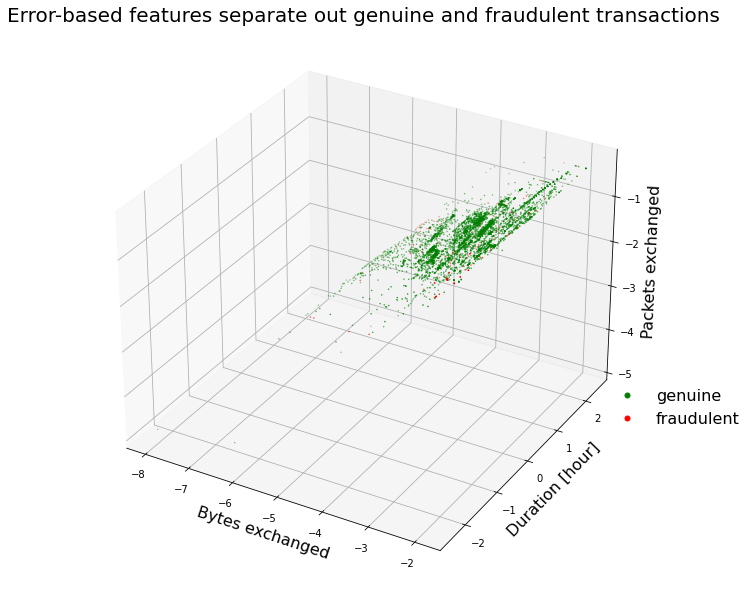

In [175]:
show3D_netflow_data(df_encoded, 'Bytes exchanged', 'Duration', 'Packets exchanged')

<AxesSubplot:>

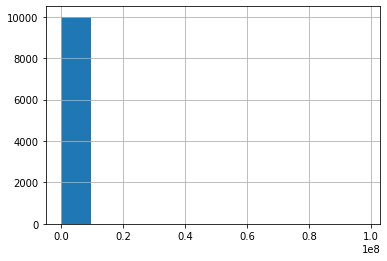

In [180]:
df_encoded['Bytes exchanged'].hist()

In [64]:
df_reduced['Source IP'].unique()

array(['211.62.96.220', '42.219.158.226', '42.219.153.155', ...,
       '75.179.204.113', '222.119.40.31', '240.156.248.137'], dtype=object)

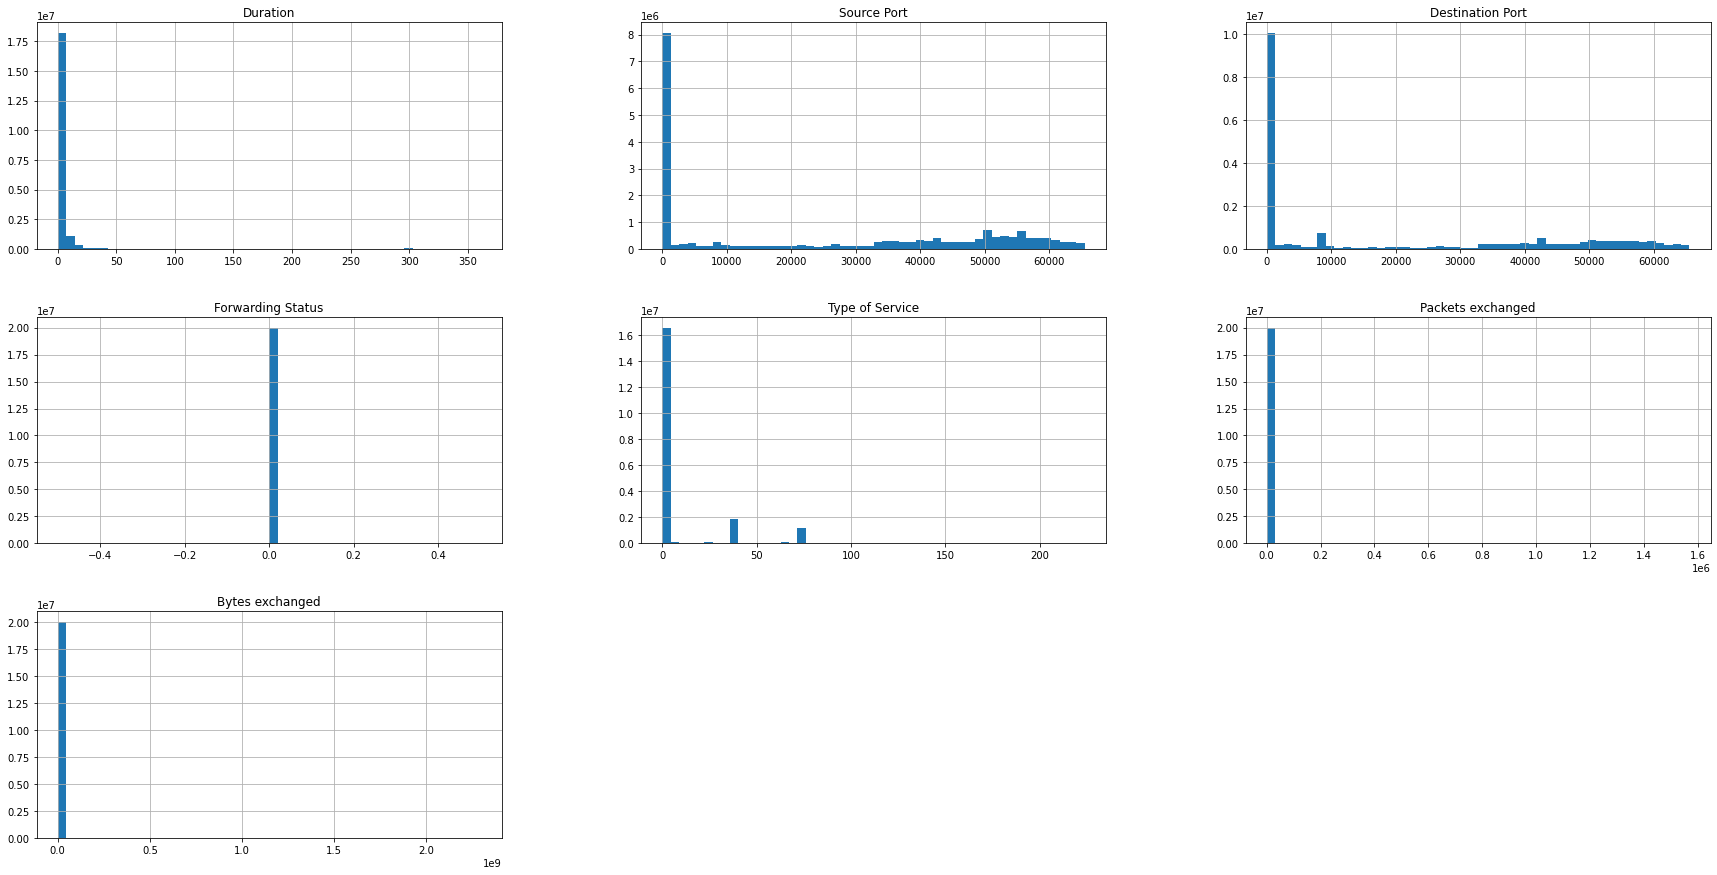

In [38]:
data_june.hist(bins=50, figsize=(30,15))
plt.show()

Next, we check if there are some useless columns on our dataset :

In [39]:
len(data_june[data_june['Type of Service'] != 0])

3695989

In [40]:
len(data_june[data_june['Forwarding Status'] != 0])

0

The Column "Forwarding Status" contains only "0", so we should drop it.

In [41]:
data_june.drop(columns='Forwarding Status', inplace=True)
data_june.head()

,Date of the end,Duration,Source IP,Destination IP,Source Port,Destination Port,Protocol,Flag,Type of Service,Packets exchanged,Bytes exchanged,Label
0,2016-06-01 00:05:01,39.364,211.62.96.220,42.219.158.212,55107,64188,UDP,.A....,0,19,3958,background
1,2016-06-01 00:05:03,39.828,42.219.158.226,71.247.111.184,80,52475,TCP,.AP.S.,0,57,79635,background
2,2016-06-01 00:05:04,36.128,42.219.153.155,223.80.226.127,443,54691,TCP,.AP.S.,0,9,2791,background
3,2016-06-01 00:05:04,36.204,223.80.226.127,42.219.153.155,54691,443,TCP,.AP.S.,0,13,3896,background
4,2016-06-01 00:05:04,42.452,42.219.153.7,42.187.82.40,53,53,UDP,.A....,0,2,175,background


In [42]:
data_june['Label'].unique()

array(['background', 'blacklist', 'anomaly-sshscan'], dtype=object)